In [1]:
# Install Git if not already installed (it's usually pre-installed on Colab)
!apt-get install git

# Clone the diffusers repository from Hugging Face's GitHub
!git clone https://github.com/huggingface/diffusers

# Change the directory to the diffusers folder
%cd diffusers

# Install the diffusers library in editable mode
!pip install -e .

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'diffusers'...
remote: Enumerating objects: 60617, done.
remote: Counting objects: 100% (617/617), done.
remote: Compressing objects: 100% (386/386), done.
remote: Total 60617 (delta 377), reused 362 (delta 200), pack-reused 60000
Receiving objects: 100% (60617/60617), 42.02 MiB | 28.84 MiB/s, done.
Resolving deltas: 100% (44071/44071), done.
/content/diffusers
Obtaining file:///content/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.28.0.dev0-0.editable-py3-none-any.whl size=11104

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install "accelerate>=0.16.0"
!pip install torchvision
!pip install "transformers>=4.25.1"
!pip install ftfy
!pip install tensorboard
!pip install Jinja2
!pip install "peft==0.7.0"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


DATA LOADING PROCESS FOR JUST IMAGES AFTER BELOW TWO CELLS  YOU CAN JUMP TO DOWNLOADING LORA_SDXL_DREAMBOOTH FILE

In [4]:
import os

# Create a local directory named 'UNCC'
local_dir = "./UNCC"
os.makedirs(local_dir, exist_ok=True)
print(f"Directory '{local_dir}' created or already exists.")


Directory './UNCC' created or already exists.


In [5]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    with open(os.path.join(local_dir, filename), 'wb') as f:
        f.write(uploaded[filename])

Saving student-union_6.jpg to student-union_6.jpg
Saving student_union_1.JPG to student_union_1.JPG
Saving student_union_2.JPG to student_union_2.JPG
Saving student_union_4.jpg to student_union_4.jpg
Saving student_union_5.jpg to student_union_5.jpg


DATA LOADING PROCESS FOR IMAGES AND CUSTOM PROMPTS *DONT RUN THIS IF THE ABOVE DATA LOADING PROCESS IS RUN*

In [24]:
import os
import glob
from PIL import Image
import json
from google.colab import files

# Setup
local_dir = "./UNCCtest/"
os.makedirs(local_dir, exist_ok=True)
os.chdir(local_dir)

# Upload images; this will upload files to the current directory
uploaded_images = files.upload()

Saving hwtc_9.txt to hwtc_9.txt
Saving hwtc_9.jpg to hwtc_9.jpg
Saving hwtc_5.txt to hwtc_5.txt
Saving hwtc_5.JPG to hwtc_5.JPG
Saving hwtc_4.txt to hwtc_4.txt
Saving hwtc_4.JPG to hwtc_4.JPG
Saving hwtc_3.txt to hwtc_3.txt
Saving hwtc_1.txt to hwtc_1.txt
Saving hwtc_8.txt to hwtc_8.txt
Saving hwtc_6.txt to hwtc_6.txt
Saving hwtc_7.txt to hwtc_7.txt
Saving hwtc_2.txt to hwtc_2.txt
Saving hwtc_8.jpg to hwtc_8.jpg
Saving hwtc_7.jpg to hwtc_7.jpg
Saving hwtc_6.jpg to hwtc_6.jpg
Saving hwtc_1.JPG to hwtc_1.JPG
Saving hwtc_2.JPG to hwtc_2.JPG
Saving hwtc_3.JPG to hwtc_3.JPG


In [25]:

os.chdir("/content/diffusers")

In [41]:
# Function to create an image grid
def image_grid(imgs, rows, cols, resize=256):
    if not imgs:
        print("No images to display.")
        return None
    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new('RGB', (cols * w, rows * h))
    for idx, img in enumerate(imgs):
        grid.paste(img, box=(idx % cols * w, idx // cols * h))
    return grid

# Load images and their corresponding text files
def load_images_and_texts(directory):
    imgs_and_texts = []
    for img_format in ['*.jpg', '*.jpeg', '*.png','*.JPG']:
        img_paths = glob.glob(os.path.join(directory, img_format))
        for img_path in img_paths:
            img = Image.open(img_path)
            txt_path = os.path.splitext(img_path)[0] + '.txt'
            imgs_and_texts.append((img_path, img, txt_path))
    return imgs_and_texts

In [42]:
imgs_and_texts = load_images_and_texts(local_dir)

imgs_to_preview = [img for _, img, _ in imgs_and_texts[:5]]
preview_grid = image_grid(imgs_to_preview, 1, 5)
preview_grid.show()


In [43]:
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
    for img_path, _, txt_path in imgs_and_texts:
        try:
            with open(txt_path, 'r') as f:
                prompt = f.read().strip()
            os.remove(txt_path)  # Remove the text file after reading
        except FileNotFoundError:
            prompt = "Prompt not found"  # Default prompt if text file is missing

        entry = {"file_name": os.path.basename(img_path), "prompt": prompt}
        json.dump(entry, outfile)
        outfile.write('\n')

In [44]:
for _, img, _ in imgs_and_texts:
    img.close()

In [45]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

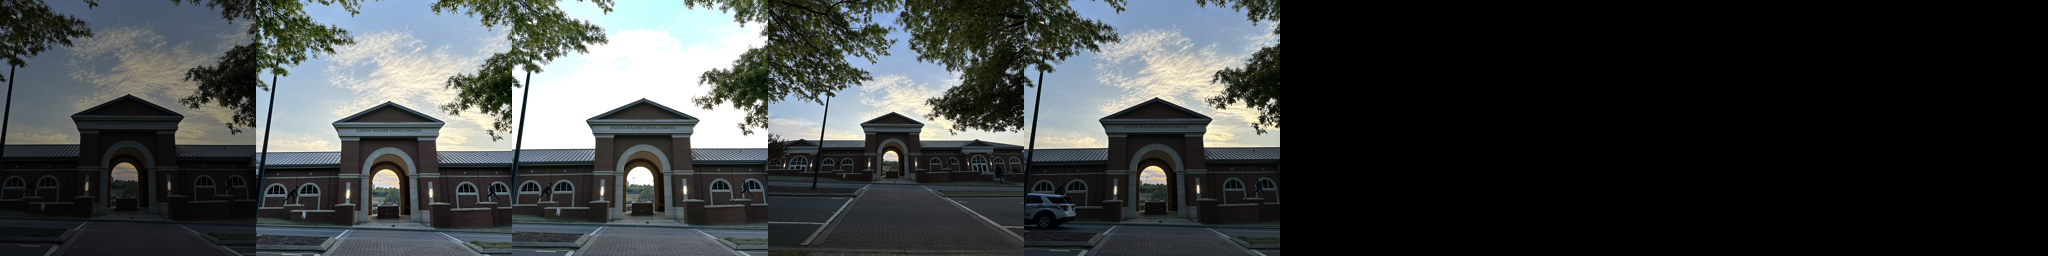

In [46]:
import glob

# change path to display images from your local dir
img_paths = "./UNCCtest/*.JPG"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 8
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [36]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 16.2 MB/s eta 0:00:00


Download dreambooth lora SDXL file from hugging face

In [32]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-04-25 03:54:29--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84307 (82K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.33K  --.-KB/s    in 0.008s  

2024-04-25 03:54:29 (9.77 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84307/84307]



login to hugging face using hugging face token

In [33]:
from huggingface_hub import notebook_login
notebook_login()

In [34]:
!pip install --upgrade peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.7.0
    Uninstalling peft-0.7.0:
      Successfully uninstalled peft-0.7.0


install weights and bias api for analyze loss and learning rate

In [35]:
!pip install wandb
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [37]:
import os

os.environ['MODEL_NAME'] = "stabilityai/stable-diffusion-xl-base-1.0"
os.environ['INSTANCE_DIR'] = "/content/diffusers/UNCC"  # Ensure this directory is correctly set up with your data
os.environ['OUTPUT_DIR'] = "/content/lora-trained-x2"
os.environ['VAE_PATH'] = "madebyollin/sdxl-vae-fp16-fix"

 if data set has images and custom prompts  use --dataset_name=" " insted of --instance_data_dir and add --caption_column="prompt"

In [39]:
training_command = f"""
python train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path={os.environ['MODEL_NAME']} \
  --instance_data_dir={os.environ['INSTANCE_DIR']} \
  --pretrained_vae_model_name_or_path={os.environ['VAE_PATH']} \
  --output_dir={os.environ['OUTPUT_DIR']} \
  --mixed_precision="fp16" \
  --instance_prompt="a photo of sks bulilding" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --learning_rate=3e-4 \
  --report_to="wandb" \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=300 \
  --validation_prompt="A photo of sks bulding at night" \
  --validation_epochs=25 \
  --seed="0" \
  --push_to_hub
"""

# Writing the command to a shell script
with open('run_training.sh', 'w') as file:
    file.write(training_command)

In [47]:
!bash run_training.sh

2024-04-25 04:02:54.453988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 04:02:54.454056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 04:02:54.455827: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 04:02:55.606673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
04/25/2024 04:02:56 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of ty

below code is to download learned lora weights

In [ ]:
import os

# Define the path to the folder and the name of the zip file
folder_path = '/content/lora-trained-xl'
zip_path = '/content/lora-trained-xl.zip'

# Compress the folder
!zip -r {zip_path} {folder_path}


  adding: content/lora-trained-xl/ (stored 0%)
  adding: content/lora-trained-xl/pytorch_lora_weights.safetensors (deflated 6%)
  adding: content/lora-trained-xl/checkpoint-500/ (stored 0%)
  adding: content/lora-trained-xl/checkpoint-500/optimizer.bin (deflated 8%)
  adding: content/lora-trained-xl/checkpoint-500/pytorch_lora_weights.safetensors (deflated 6%)
  adding: content/lora-trained-xl/checkpoint-500/random_states_0.pkl (deflated 25%)
  adding: content/lora-trained-xl/checkpoint-500/scheduler.bin (deflated 56%)
  adding: content/lora-trained-xl/checkpoint-500/scaler.pt (deflated 60%)


In [ ]:
from google.colab import files

# Download the file to your local computer
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>